In [2]:
import sys
sys.path += ["../src"]
import utils
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib.pyplot import subplots as sbp 
from importlib import reload
import jl_vae
# import jl_nflows_geo_coordinates_2 as nfg
# from jl_nflows_geo_coordinates import load_nf as load_dict

from _51_abm_functions import cod_prov_abbrv_df

# Global Spatial Autocorrelation
from spatial_autocorrelation import get_moransI, moransI_scatterplot, hypothesis_testing
# Local Spatial Autocorrelation
from spatial_autocorrelation import get_localMoransI, LISA_scatterplot
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
# import dictionary with data {'hydro_risk', 'census', 'omi_og', 'cap'}
# takes ~25seconds
geo_dict = jl_vae.load_geo_data()

In [3]:
# transform one-hot encoding to categories
def add_cat_features(df):
    df["energy_class"] = df[[u for u in df.columns if "_energy" in u]].stack().rename("col").reset_index().query("col == 1")["level_1"]
    df["COD_CAT"] = [u[8:] for u in df[[u for u in df.columns if "COD_CAT_" in u]].stack().rename("col").reset_index().query("col == 1")["level_1"]]
    df["anno_costruzione"] = [u[17:] for u in df[[u for u in df.columns if "ANNO_COSTRUZIONE" in u]].stack().rename("col").reset_index().query("col == 1")["level_1"]]
    return df


In [4]:
# check which provinces are done
glob(jl_vae.path_pop_synth + f"95sample/pop_samples/*")

['/data/housing/data/intermediate/jl_pop_synth/95sample/pop_samples/synthetic_pop_full_250703BG.csv',
 '/data/housing/data/intermediate/jl_pop_synth/95sample/pop_samples/synthetic_pop_full_250703AO.csv',
 '/data/housing/data/intermediate/jl_pop_synth/95sample/pop_samples/synthetic_pop_full_250703BO.csv',
 '/data/housing/data/intermediate/jl_pop_synth/95sample/pop_samples/synthetic_pop_full_250703AL.csv',
 '/data/housing/data/intermediate/jl_pop_synth/95sample/pop_samples/synthetic_pop_full_250703AQ.csv',
 '/data/housing/data/intermediate/jl_pop_synth/95sample/pop_samples/synthetic_pop_full_250703AN.csv',
 '/data/housing/data/intermediate/jl_pop_synth/95sample/pop_samples/synthetic_pop_full_250703BA.csv',
 '/data/housing/data/intermediate/jl_pop_synth/95sample/pop_samples/synthetic_pop_full_250703AR.csv',
 '/data/housing/data/intermediate/jl_pop_synth/95sample/pop_samples/synthetic_pop_full_250703BL.csv',
 '/data/housing/data/intermediate/jl_pop_synth/95sample/pop_samples/synthetic_pop_

In [5]:
# paths of the synthetic and real populations

# choose the province
prov = "AN"
# get the cod prov (number)
cod_prov = cod_prov_abbrv_df.query("prov_abbrv == @prov")["COD_PROV"].item()

# all trained models have these settings
date_nf = "241203"
date_vae = "240107"
date_vae = "250709price_"
date_95 = "250703"
date_data = "250110"

real_pops = jl_vae.path_pop_synth + f"pop_samples/pop_real_with_hedonic_price"
# synth_pops = jl_vae.path_pop_synth + f"pop_samples/pop_synth_with_hedonic_price_250110"
synth_pops = jl_vae.path_pop_synth + f"pop_samples/"

vae_data = "full"

synth_pops95 = jl_vae.path_pop_synth + f"95sample/pop_samples"

In [6]:
# df_real = pd.read_csv(real_pops + f"/pop_real_full_250110{prov}.csv", index_col = 0)
df_real = jl_vae.get_df_prov(prov, dropna = False, add_cols = ["log_price"])
# df_sample = pd.read_csv(synth_pops + f"/pop_synth_full_250110{prov}.csv", index_col = 0).query("prov_abbrv == @prov")
df_sample = pd.read_csv(synth_pops + f"/synthetic_pop_full_{date_vae}{prov}.csv", index_col = 0)
# spatial matching to assign geographical features to synthetic data
# this select the observations within province borders
df_sample95 = pd.read_csv(synth_pops95 + f"/synthetic_pop_full_{date_95}{prov}.csv", index_col = 0)
df_sample95 = (utils.spatial_matching_ABM(df_sample95,
                                           hydro_risk = geo_dict["hydro_risk"], 
                                           census = geo_dict["census"], 
                                           omi_og = geo_dict["omi_og"], 
                                           cap = geo_dict["cap"])
                .rename(columns = {"GEO_LONGITUDINE_BENE_ROUNDED": "x", 
                                   "GEO_LATITUDINE_BENE_ROUNDED": "y"})
                .query("prov_abbrv == @prov")
                                           )
    

df_real = add_cat_features(df_real)
df_sample = add_cat_features(df_sample).sample(n = len(df_real), random_state = 79)
df_sample95 = add_cat_features(df_sample95).sample(n = len(df_real), random_state = 79)

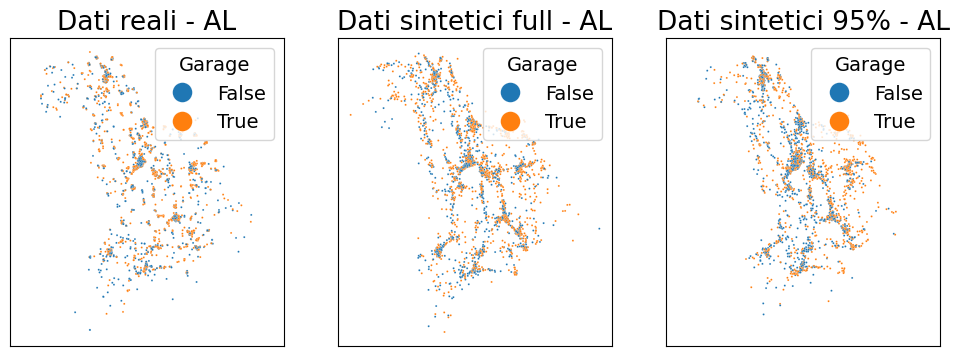

In [35]:
fig, axes = sbp(ncols = 3, figsize = (12,4), sharex = True, sharey = True)

for j,df_plot in enumerate([df_real.assign(flag_garage = lambda x: x["flag_garage"] == 1), 
                            df_sample, 
                            df_sample95]):
    sns.scatterplot(data = df_plot,
                    hue = "flag_garage", 
                    # hue = "flag_garage", 
                    x = "x", y = "y", s = 2, ax = axes[j])
    # axes[j].set_title(prov + " " + ["Real", "Synthetic"][j])
    axes[j].set_title("Dati " + ["reali", "sintetici full", "sintetici 95%"][j] + " - " + prov, fontsize = 19)
    axes[j].get_xaxis().set_visible(False)
    axes[j].get_yaxis().set_visible(False)
# axes[0].legend().set_visible(False)
    axes[j].legend(fontsize = 14, markerscale = 10, title_fontsize = 14).set_title("Garage")

In [17]:
df_real = (df_real[[u for u in jl_vae.cols if u not in ["prov_abbrv"]] + ["x_norm", "y_norm"]]
           .assign(flag_air_conditioning_Missing = lambda x: x["flag_air_conditioning"] == "Missing",
                   flag_multi_floor_Missing = lambda x: x["flag_multi_floor"] == "Missing")
                   .replace("Missing",0).astype(float))

# this is the fraction of real data that I used to train the 0.95 model 
df_real95 = df_real.sample(frac = 0.95, random_state = 1111)

# real observations that have not been used to train the model
df_real_excluded = df_real.loc[~df_real.index.isin(df_real95.index)].drop(columns = ["x_norm", "y_norm", "flag_geo_valid"])

# keep all dataset with the same format
df_sample_col = df_sample[df_real_excluded.columns] + 0.
df_sample95_col = df_sample95[df_real_excluded.columns] + 0.

In [23]:
df_real_excluded

,flag_garage,flag_pertinenza,flag_air_conditioning,flag_multi_floor,y,x,log_mq,ANNO_COSTRUZIONE_1500_1965,ANNO_COSTRUZIONE_1965_1985,ANNO_COSTRUZIONE_1985_2005,...,COD_CAT_A_01_07_08,COD_CAT_A_04_05,floor_0.0,floor_1.0,floor_2.0,floor_3.0,floor_Missing,floor_plus_4,flag_air_conditioning_Missing,flag_multi_floor_Missing
513265,0.0,0.0,0.0,0.0,45.759,7.032,3.988984,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
513267,1.0,0.0,0.0,0.0,45.749,7.607,4.465908,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
513302,0.0,0.0,0.0,0.0,45.753,7.078,4.234107,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
513338,1.0,0.0,0.0,0.0,45.812,7.688,4.094345,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
513352,0.0,1.0,0.0,0.0,45.723,7.264,3.637586,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514615,1.0,0.0,0.0,0.0,45.727,7.278,4.094345,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
514620,1.0,0.0,0.0,0.0,45.744,7.654,4.317488,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
514626,0.0,0.0,0.0,0.0,45.630,7.327,3.828641,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
514667,0.0,1.0,0.0,0.0,45.738,7.303,4.077537,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [18]:
# this function return the minimum between all the distances between one dataset and one observation
#
# the distances are computed as quadratic forms of the differences D = GWG^T, where G_ij = m_i - m_j and
# W is the weight matrix
# if W = I, this is the euclidean distance
# if W = cov(X)^-1 this is the Mahalanobis distance
# some features can have 0 variance (like class in one-hot encodings), so I replace 0 with 0.1
def compute_minimum_distance(df1, df2):
    diff_df = np.array(df1) - np.array(df2)
    weights = (df1.var().replace(0, 0.1)) ** -1
    weights[["x", "y"]] = weights[["x", "y"]] * 2
    W = np.diag(weights)
    distance_df = diff_df @ W @ diff_df.T
    all_distances = np.diag(distance_df)
    min_distance = np.min(all_distances)
    return min_distance

In [19]:
# compute all minimum distances between (i) synthetic dataset and excluded observations and 
# (ii) synthetic dataset 0.95 and excluded observations
all_excluded_min_distance = [(compute_minimum_distance(df_sample_col, excluded_obs), 
  compute_minimum_distance(df_sample95_col, excluded_obs)) 
  for _, excluded_obs in df_real_excluded.iterrows()]

In [20]:
df_min_distances = pd.DataFrame(all_excluded_min_distance, columns = ["complete_data", "95_data"])

In [21]:
df_min_distances.mean(), df_min_distances.std()

(complete_data    13.131016
 95_data          14.233581
 dtype: float64,
 complete_data    10.816348
 95_data          12.065757
 dtype: float64)

<Axes: xlabel='complete_data', ylabel='95_data'>

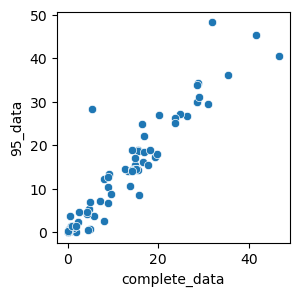

In [22]:
fig, axes = sbp(figsize = (3,3))
sns.scatterplot(data = df_min_distances, x = "complete_data", y = "95_data")